# Main Analysis Pipeline
 
 * Prepare Hough transform based only on wire information (= energy, time, radial distance)
 * Build predictions based on Hough, local information, and local information of left/right neighbors 

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CyDetHits, CTHHits, CDCHits, FlatHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def flatten_data(data, keys, samples, n_features):
    return pandas.DataFrame(data=data[samples].reshape(-1, n_features), columns=keys)

def mask(data, pol=None):
    if pol==None:
        return data[data['labels'] != 0]
    if pol==0:
        return data[(data['labels'] != 0) & (data['Polarity'] == 0)]
    if pol==1:
        return data[(data['labels'] != 0) & (data['Polarity'] != 0)]

def predict_classifier(classifier, data_samp):
    """
    Return predictions where no hit has zero response by definition.  Return both
    flat predictions, and event sorted predicitions
    """
    # Get the predictions
    pred_evt = classifier.predict_proba(data_samp)[:,1]

    # Check which wires have hits, which ones do not
    not_hit = (data_samp['labels'] == 0).values
    has_hit = (data_samp['labels'] != 0).values

    # Define hit-less wires as definitely not being signal
    pred_evt[not_hit] = 0

    # Slim down the result to a copy with only hits
    pred = pred_evt[has_hit]
    # Reshape the result to be the event shape, for the hoguh transform
    pred_evt = pred_evt.reshape(-1, geom.n_points)
    
    return pred, pred_evt

## Import Signal Hits

In [3]:
file_base = "/vols/comet00/users/elg112/ICEDUST"\
            "/local_storage/SimDetectorResponse_tree"\
            "/test_signal_sample/03000014_"
cdc_sig_file = file_base + "cdc_sum_sig.root"
cth_sig_file = file_base + "cth_mc_sig.root"

In [4]:
file_base = "/vols/comet00/users/elg112/ICEDUST"\
            "/local_storage/SimDetectorResponse_tree"\
            "/test_signal_sample/100k_"
cdc_sig_file = file_base + "cdc_sum_hits.root"
cth_sig_file = file_base + "cth_mc_hits.root"

In [5]:
# Define some branches to import
## Existing branches
prefix = "CDCHit.f"
drift_name = prefix + "DriftTime"
track_id_name = prefix + "Track.fTrackID"
## Branches to be filled
row_name = "Layers"
lcl_scr_name = prefix + "Local_Score"
ngh_scr_name = prefix + "Neigh_Score"
hgh_scr_name = prefix + "Hough_Score"
trk_scr_name = prefix + "Track_Score"
rel_time_name = prefix + "Relative_Time"
take_hit_name = prefix + "Take_Hit"
## Kinda both
sig_flag = "IsSig"

In [6]:
these_branches = [drift_name, track_id_name]
empty_branches = [prefix + row_name, 
                  lcl_scr_name, 
                  ngh_scr_name, 
                  hgh_scr_name,
                  trk_scr_name, 
                  rel_time_name,
                  take_hit_name]

In [7]:
sig_cdc = CyDetHits(cdc_sig_file, 
                      signal_coding=[1], 
                      hit_type_name=sig_flag,
                      row_name=row_name,
                      branches=these_branches,
                      empty_branches=empty_branches)
sig_cdc.data[sig_cdc.hit_type_name] = sig_cdc.data[track_id_name] == 1
print sig_cdc.n_events

52640


In [8]:
sig_cth = FlatHits(cth_sig_file,
                  tree="COMETEventsSummary",
                  signal_coding=[1], 
                  hit_type_name=sig_flag,
                  prefix="CTHHit.f",
                  branches=["CTHHit.fMCPos.fE",
                            "CTHHit.fChannel",
                            "CTHHit.fCharge"])
print sig_cth.n_events

43087


In [9]:
from cylinder import CyDet
geom = CyDet()
n_events = sig_cth.n_events

### Only keep events with hits in both CTH and CDC

In [10]:
print len(np.intersect1d(np.random.randint(0, 100000, sig_cdc.n_events), 
                         np.random.randint(0, 100000, sig_cth.n_events)))

14392


In [11]:
passed_events = np.intersect1d(sig_cth.get_signal_hits()[sig_cth.key_name], 
                               sig_cdc.get_signal_hits()[sig_cdc.key_name])
sig_cdc.trim_hits(sig_cdc.key_name, values=passed_events)
sig_cth.trim_hits(sig_cth.key_name, values=passed_events)
print len(passed_events)

20759


### Smear the hits by the bunch width

In [12]:
random_time_smear = np.random.randint(-50,50, size=len(passed_events))

In [13]:
cdc_time_smear = random_time_smear[sig_cdc.hits_to_events]
cth_time_smear = random_time_smear[sig_cth.hits_to_events]

In [14]:
sig_cdc.data[sig_cdc.time_name] += cdc_time_smear
sig_cth.data["CTHHit.fMCPos.fE"] += cth_time_smear

### Add the drift time to the CDC hits

In [15]:
sig_cdc.data[sig_cdc.time_name] += sig_cdc.data[drift_name]

## Cuts on the Signal Tracks

In [16]:
# Define cuts to use
n_hits_cut = True
layer_cut = True
timing_cut = True
use_cth_cut = True

### Fiducial Time Window Cuts

In [17]:
# First reduce each CTH hit to the earliest signal hit in that channel
hits_to_keep = []
for evt in range(sig_cth.n_events):
    sig_hits = sig_cth.get_signal_hits(evt)
    for chan in np.unique(sig_hits["CTHHit.fChannel"]):
        hits_to_keep.append(sig_cth.filter_hits(sig_hits, "CTHHit.fChannel", values=chan)[sig_cth.hits_index_name][0])

In [18]:
print sig_cth.n_hits
sig_cth.trim_hits(sig_cth.hits_index_name, values=hits_to_keep)
print sig_cth.n_hits

10020536
92335


In [19]:
if timing_cut:
    # Apply the timing filter
    print "Before timing cut"
    before_cdc_nhits = sig_cdc.n_hits
    before_cth_nhits = sig_cth.n_hits
    print "CTH Hits: {}".format(before_cth_nhits)
    print "CDC Hits: {}".format(before_cdc_nhits)
    sig_cth.trim_hits(variable="CTHHit.fMCPos.fE", greater_than=500, less_than=1170)
    sig_cdc.trim_hits(variable=sig_cdc.time_name, greater_than=500, less_than=1620)
    print "After timing cut"
    print "CTH Hits: {0}, {1:.4f}".format(sig_cth.n_hits, float(sig_cth.n_hits)/before_cth_nhits)
    print "CDC Hits: {0}, {1:.4f}".format(sig_cdc.n_hits, float(sig_cdc.n_hits)/before_cdc_nhits)

Before timing cut
CTH Hits: 92335
CDC Hits: 1812246
After timing cut
CTH Hits: 43232, 0.4682
CDC Hits: 919140, 0.5072


In [20]:
passed_events = np.intersect1d(sig_cth.get_events()[sig_cth.key_name], 
                               sig_cdc.get_events()[sig_cdc.key_name])
sig_cdc.trim_hits(sig_cdc.key_name, values=passed_events)
sig_cth.trim_hits(sig_cth.key_name, values=passed_events)
print len(passed_events)

5190


### Cuts on CTH

In [21]:
# Filter for CTH in time window.  Get the time
print sig_cth.n_events
trigger_events = []
for evt in range(sig_cth.n_events):
    sig_hits = sig_cth.get_signal_hits(evt)
    if len(sig_hits) != 0:
        trigger_events.append(evt)
trigger_events = np.array(trigger_events)
print "Events that pass CTH Trigger: {}".format(len(trigger_events))

5190
Events that pass CTH Trigger: 5190


### Cuts on CyDet

In [22]:
# Filter for max layer is five
max_layer = []
for evt in range(sig_cdc.n_events):
    these_layers = sig_cdc.geom.point_layers[sig_cdc.get_sig_wires(evt)]
    if len(sig_cdc.get_sig_wires(evt)) != 0:
        max_layer.append(np.max(these_layers))
    else:
        max_layer.append(-1)
max_layer = np.array(max_layer)
good_max_layer = np.where(max_layer >= 4)[0]
print "Passed Max Layer {}".format(len(good_max_layer))

Passed Max Layer 4316


In [23]:
# Filter for number of signal hits
n_signal_hits  = np.array([len(sig_cdc.get_signal_hits(evt)) 
                         for evt in range(sig_cth.n_events)])
n_signal_hits = np.array(n_signal_hits)
good_n_hits = np.where(n_signal_hits >= 30)[0]
print "Passed Good Number of Hits : {}".format(len(good_n_hits))

Passed Good Number of Hits : 4387


### Apply the cuts

In [24]:
if use_cth_cut:
    passed_events = np.intersect1d(passed_events, sig_cth.get_events(trigger_events)[sig_cth.key_name])
    print "Removed due to CTH Trigger {}".format(sig_cth.n_events - len(trigger_events))
if layer_cut:
    passed_events = np.intersect1d(passed_events, sig_cdc.get_events(good_max_layer)[sig_cdc.key_name])
    print "Removed due to Layer Cut {}".format(sig_cdc.n_events - len(good_max_layer))
if n_hits_cut:
    passed_events = np.intersect1d(passed_events, sig_cdc.get_events(good_n_hits)[sig_cdc.key_name])
    print "Removed due to N Hits Cut {}".format(sig_cdc.n_events - len(good_n_hits))

Removed due to CTH Trigger 0
Removed due to Layer Cut 874
Removed due to N Hits Cut 803


In [25]:
print "After All Cuts {}".format(len(passed_events))

After All Cuts 4071


In [26]:
sig_cdc.trim_hits(sig_cdc.key_name, values=passed_events)
sig_cth.trim_hits(sig_cth.key_name, values=passed_events)

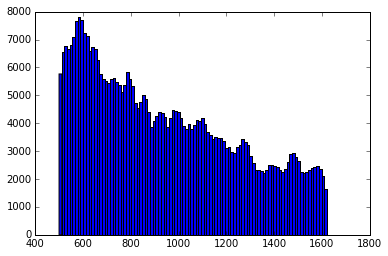

In [27]:
plt.hist(sig_cdc.get_events()[sig_cdc.time_name], bins=100)
show()

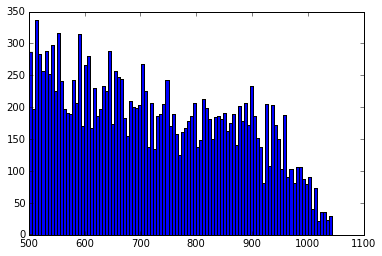

In [28]:
plt.hist(sig_cth.get_events()["CTHHit.fMCPos.fE"], bins=100)
show()

## Prepare the data

In [29]:
from tracking import HoughSpace
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve

In [30]:
back_sample = "/vols/comet00/users/elg112/ICEDUST"\
              "/local_storage/MC3b_tree"\
              "/loose_timing_cut/event_root"\
              "/1_2500_merged_cdc_sum_hit.root"

In [31]:
import hits
reload(hits)
from hits import CyDetHits

In [32]:
back_cdc = CyDetHits(back_sample, 
                     signal_coding=[1], 
                     row_name=row_name,
                     hit_type_name=sig_flag,
                     branches=these_branches,
                     empty_branches=empty_branches)
back_cdc.data[back_cdc.time_name] += back_cdc.data[drift_name]

In [33]:
if timing_cut:
    # Apply the timing filter
    print "Back Events : {}".format(back_cdc.n_events)
    print "CyDet Hits: {}".format(back_cdc.n_hits)
    back_cdc.trim_hits(variable=back_cdc.time_name, less_than=1620, greater_than=500)
    print "CyDet Hits: {}".format(back_cdc.n_hits)
    print "Back Events : {}".format(back_cdc.n_events)

Back Events : 2495
CyDet Hits: 3555529
CyDet Hits: 1696049
Back Events : 2495


### Add in the Signal events

In [34]:
n_events = min(back_cdc.n_events, sig_cdc.n_events)

In [35]:
print len(sig_cdc.get_signal_hits())
print len(sig_cdc.get_background_hits())
print len(back_cdc.get_signal_hits())
print len(back_cdc.get_background_hits())

409197
3594
0
1696049


In [36]:
back_cdc.trim_events(range(n_events))
sig_cdc.trim_events(range(n_events))

In [37]:
print len(sig_cdc.get_signal_hits())
print len(sig_cdc.get_background_hits())
print len(back_cdc.get_signal_hits())
print len(back_cdc.get_background_hits())

250616
2337
0
1696049


In [38]:
print memory_usage()
hits_cdc = back_cdc
hits_cdc.add_hits(sig_cdc.data)
print memory_usage()

[1178.84375]
[1208.75390625]


In [39]:
print memory_usage()
del sig_cdc
print memory_usage()

[1208.75390625]
[1055.48828125]


### Set the Layer Value

In [40]:
hits_cdc.data[hits_cdc.row_name] = geom.point_layers[hits_cdc.get_events()[hits_cdc.flat_name]]

### Set the trigger time and Relative Timing

In [41]:
# Set the trigger times
trig_time_evt = []
for evt in range(n_events):
    sig_hits = sig_cth.get_signal_hits(evt)
    if len(sig_hits) != 0:
        this_trig_time = np.amin(sig_hits["CTHHit.fMCPos.fE"])
        trig_time_evt.append(this_trig_time)
        hits_cdc.data[hits_cdc.trig_name][hits_cdc.event_to_hits[evt]] = this_trig_time

In [42]:
# Set the relative timing
hits_cdc.data[rel_time_name] = hits_cdc.data[hits_cdc.time_name] - hits_cdc.data[hits_cdc.trig_name]

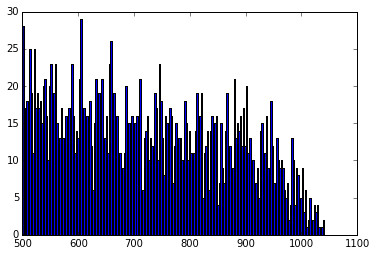

In [43]:
plt.hist(trig_time_evt, bins=200)
plt.show()

# Begin the Analysis

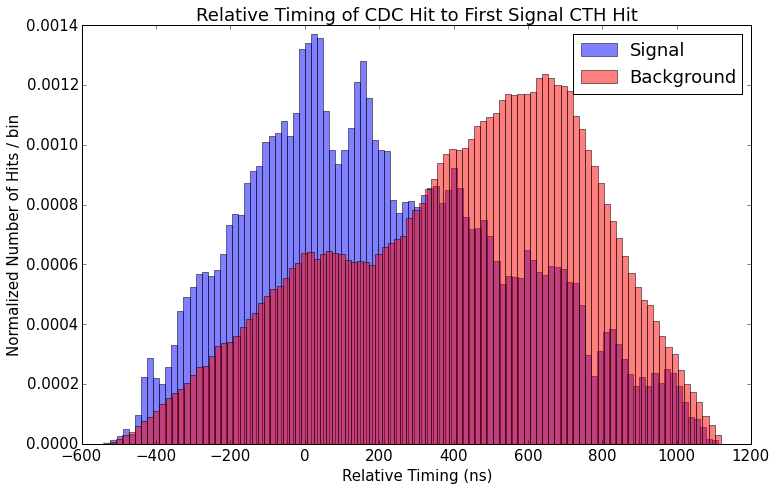

In [118]:
plot_set_font()
figsize(12,7.5)
plt.title("Relative Timing of CDC Hit to First Signal CTH Hit")
plt.xlabel("Relative Timing (ns)")
plt.ylabel("Normalized Number of Hits / bin")
plt.hist(hits_cdc.get_signal_hits()[rel_time_name], 
         bins=100,  color='blue', alpha=0.5, normed=True, label="Signal")
plt.hist(hits_cdc.get_background_hits()[rel_time_name], 
         bins=100,  color='red', alpha=0.5, normed=True, label="Background")
plt.legend()
show()

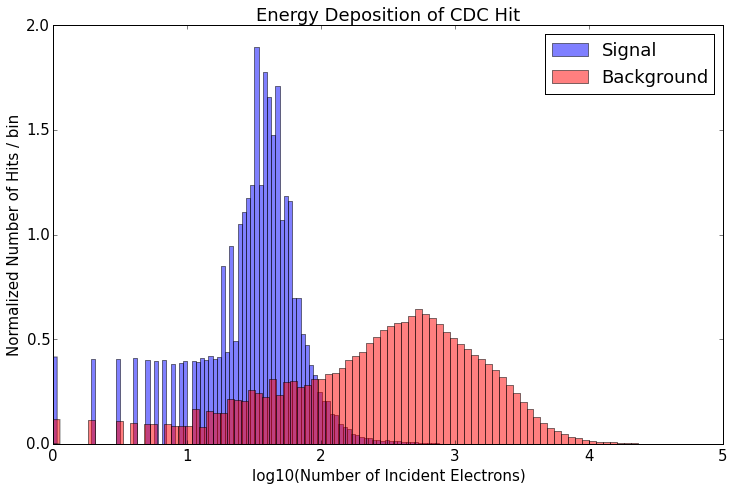

In [45]:
plt.title("Energy Deposition of CDC Hit")
plt.xlabel("log10(Number of Incident Electrons)")
plt.ylabel("Normalized Number of Hits / bin")
plt.xlim(0,5)
regular = 0
plt.hist(np.log10(hits_cdc.get_signal_hits()[hits_cdc.edep_name]), 
         bins=100,  color='blue', alpha=0.5, normed=True, label="Signal")
plt.hist(np.log10(hits_cdc.get_background_hits()[hits_cdc.edep_name]), 
         bins=100,  color='red', alpha=0.5, normed=True, label="Background")
plt.legend()
show()

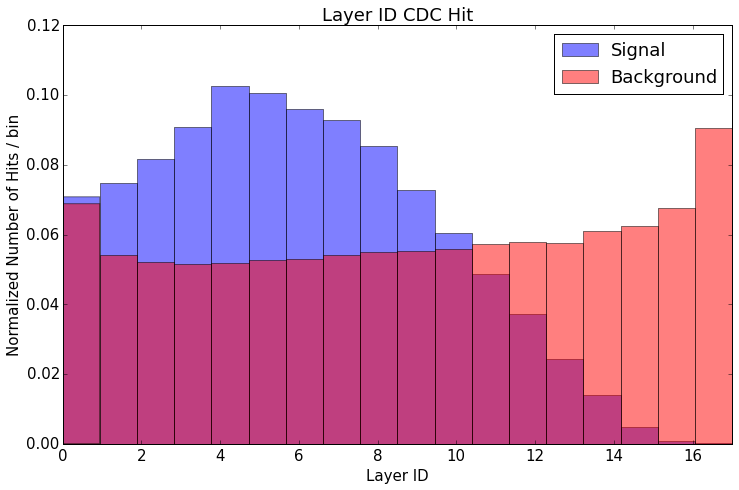

In [46]:
plt.title("Layer ID CDC Hit")
plt.xlabel("Layer ID")
plt.ylabel("Normalized Number of Hits / bin")
plt.hist(geom.point_layers[hits_cdc.get_signal_hits()[hits_cdc.flat_name]], 
         bins=18,  color='blue', alpha=0.5, normed=True, label="Signal")
plt.hist(geom.point_layers[hits_cdc.get_background_hits()[hits_cdc.flat_name]], 
         bins=18,  color='red', alpha=0.5, normed=True, label="Background")
plt.xlim(0,17)
plt.legend()
show()

In [47]:
sig_occupancy = []
back_occupancy = []
occupancy = []

for event in range(hits_cdc.n_events):
    sig_occupancy += [len(np.unique(hits_cdc.get_signal_hits(event)[hits_cdc.flat_name]))]
    back_occupancy += [len(np.unique(hits_cdc.get_background_hits(event)[hits_cdc.flat_name]))]
    occupancy += [len(np.unique(hits_cdc.get_events(event)[hits_cdc.flat_name]))]    

In [93]:
avg_n_hits = np.average(hits_cdc.event_to_n_hits)
avg_n_hits = np.average(hits_cdc.event_to_n_hits)
avg_occ = np.average(occupancy)
print np.average(sig_occupancy), np.average(back_occupancy)

print avg_occ, avg_occ/4482
print avg_n_hits, (avg_n_hits - avg_occ)/float(avg_occ)

77.4865731463 588.185571142
655.253306613 0.146196632444
655.253306613 0.0


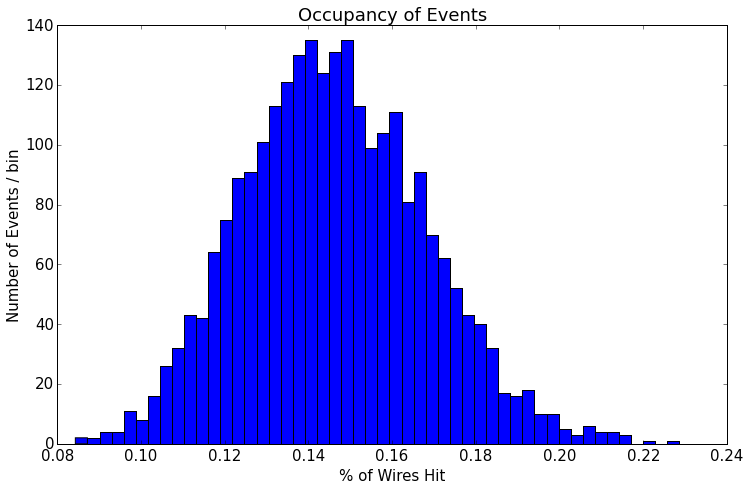

In [49]:
plt.title("Occupancy of Events")
plt.xlabel("% of Wires Hit")
plt.ylabel("Number of Events / bin")
plt.hist(np.array(occupancy)/4482., bins=50)
plt.show()

In [50]:
for event in range(0):
    to_plot = np.zeros(4482)
    to_plot[hits_cdc.get_background_hits(event)[hits_cdc.flat_name]] = 2
    to_plot[hits_cdc.get_signal_hits(event)[hits_cdc.flat_name]] = 1
    plot_output(to_plot, geom)
    plt.show()

## Local Classification : Deal with Coincidence

### Make training/testing splits

In [51]:
def reset_masks(evt_samp, hit_sample):
    total_events = hit_sample.n_events
    total_hits = hit_sample.n_hits

    evt_samp_masks = [ np.zeros(total_events, dtype=bool) for samp in evt_samp ]
    hit_masks      = [ np.zeros(total_hits, dtype=bool) for samp in evt_samp ]
    for i in range(len(evt_samp)):
        evt_samp_masks[i][evt_samp[i]] = True
        hit_masks[i][hit_sample.get_events(evt_samp[i])[hit_sample.hits_index_name]] = True
    return evt_samp_masks, hit_masks

In [52]:
# Split up the data first
from sklearn.cross_validation import train_test_split

# Seed for sample mixing
seed = 10

# Get samples
rest = range(hits_cdc.n_events)
rest, sample_4     = train_test_split(rest, train_size=0.675, test_size=0.225, random_state=seed)
rest, sample_3     = train_test_split(rest, train_size=0.66, test_size=0.33, random_state=seed)
sample_1, sample_2 = train_test_split(rest, train_size=0.5, test_size=0.5, random_state=seed)

# Get event masks
evt_samp       = [ sample_1, sample_2, sample_3, sample_4 ]
evt_samp_masks, hit_masks = reset_masks(evt_samp, hits_cdc)

### Classify Using Local Features

In [53]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc
from pandas import DataFrame

In [54]:
# Define Data
train_features = [hits_cdc.edep_name, rel_time_name, hits_cdc.row_name]

In [55]:
factory = ClassifiersFactory()

# Define GBDT over neighbour-level features
local_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=train_features)
# Add the GBDT
factory.add_classifier('Local Features', local_gbdt)

In [56]:
# Train the classifier
factory.fit(DataFrame(hits_cdc.data[train_features][hit_masks[0]]), 
            hits_cdc.data[hits_cdc.hit_type_name][hit_masks[0]])
pass

model Local Features was trained in 49.81 seconds
Totally spent 49.81 seconds on training


In [57]:
hits_cdc.print_branches()

Branches available are:
CDCHit.fDriftTime
CDCHit.fTrack.fTrackID
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fHough_Score
CDCHit.fIsSig
CDCHit.fLayers
CDCHit.fLocal_Score
CDCHit.fNeigh_Score
CDCHit.fRelative_Time
CDCHit.fTake_Hit
CDCHit.fTrack_Score
CDCHit.fTrigTime
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fMCPos.fE


In [58]:
# Print these predictions
hits_cdc.data[lcl_scr_name] = local_gbdt.predict_proba(DataFrame(hits_cdc.data[train_features]))[:,1]
# Invalidate the training sample
hits_cdc.data[lcl_scr_name][hit_masks[0]] = -1

In [59]:
# Sort events by channel, by score
hits_cdc.sort_hits([hits_cdc.flat_name, lcl_scr_name])
# Recored which hit have the best score by event by channel
all_hits_to_take = []
# Stats about hit removal
removal_stats = {"is_sig, more_sig"    : 0,
                 "is_sig, no_more_sig" : 0,
                 "not_sig, more_sig"    : 0,
                 "not_sig, no_sig"      : 0}

# Loop over all events
for evt in range(hits_cdc.n_events):
    event_hits = hits_cdc.get_events(evt)
    for channel in np.unique(event_hits[hits_cdc.flat_name]):
        chan_hits = hits_cdc.filter_hits(event_hits, hits_cdc.flat_name, channel)
        this_chan_hit = chan_hits[hits_cdc.hits_index_name][-1]
        all_hits_to_take.append(this_chan_hit)
        # Check for coincidence
        if len(chan_hits) > 1:
            # Check the channel content
            is_sig = hits_cdc.data[this_chan_hit][hits_cdc.hit_type_name] == 1
            # Check if there was more signal
            has_more_sig = (sum(chan_hits[hits_cdc.hit_type_name] == 1) - is_sig) > 0
            # Check which hit we chose
            if is_sig and has_more_sig:
                removal_stats["is_sig, more_sig"] += 1
            elif is_sig and not has_more_sig:
                removal_stats["is_sig, no_more_sig"] += 1
            elif not is_sig and has_more_sig:
                removal_stats["not_sig, more_sig"] += 1
            else:
                removal_stats["not_sig, no_sig"] += 1

In [60]:
pprint(removal_stats)
print sum(hits_cdc.get_events()["CDCHit.fIsSig"])
print sum(removal_stats.values())

{'is_sig, more_sig': 39130,
 'is_sig, no_more_sig': 17050,
 'not_sig, more_sig': 4021,
 'not_sig, no_sig': 183333}
250616.0
243534


In [61]:
# Make a mask
chan_hit_mask = np.zeros(hits_cdc.n_hits, dtype=bool)
chan_hit_mask[all_hits_to_take] = 1
# Set the hits to take as channel hit
hits_cdc.data[take_hit_name][chan_hit_mask] = 1
# Trim the hits we are not going to look at
hits_cdc.trim_hits(take_hit_name, values=1)
hits_cdc.sort_hits(hits_cdc.flat_name)
evt_samp_masks, hit_masks = reset_masks(evt_samp, hits_cdc)

0.944270003226


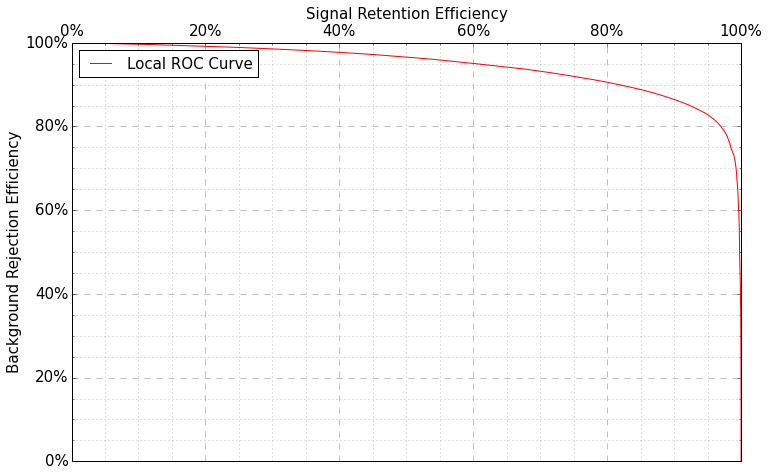

In [62]:
plot_roc_curve(hits_cdc.data[hits_cdc.hit_type_name][np.logical_not(hit_masks[0])], 
               hits_cdc.data[lcl_scr_name][np.logical_not(hit_masks[0])], 
               zoom=False, label="Local ROC Curve")
print roc_auc_score(hits_cdc.data[hits_cdc.hit_type_name][np.logical_not(hit_masks[0])], 
               hits_cdc.data[lcl_scr_name][np.logical_not(hit_masks[0])])
plt.show()

## Use Neighbour Level Features

In [63]:
# Define Data
neigh_train_features = [hits_cdc.edep_name, 
                        hits_cdc.edep_name + "_left",
                        hits_cdc.edep_name + "_right",
                        rel_time_name, 
                        rel_time_name + "_left",
                        rel_time_name + "_right",
                        hits_cdc.row_name]

In [64]:
# Define GBDT over neighbour-level features
neigh_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=neigh_train_features)
# Add the GBDT
factory.add_classifier('Neighbour and Local Features', neigh_gbdt)

In [65]:
# Train the classifier
factory.fit(DataFrame(np.vstack(
                    [hits_cdc.get_measurement(hits_cdc.edep_name, 
                                              evt_samp[1], 
                                              shift=i, 
                                              only_hits=True, 
                                              flatten=True) for i in [0,-1,1]] +\
                    [hits_cdc.get_measurement(hits_cdc.time_name, 
                                              evt_samp[1], 
                                              shift=i, 
                                              only_hits=True, 
                                              flatten=True) for i in [0,-1,1]] +\
                    [hits_cdc.get_measurement(hits_cdc.row_name,
                                              evt_samp[1],
                                              only_hits=True,
                                              flatten=True)]).T,
                    columns=neigh_train_features), 
            hits_cdc.get_measurement(hits_cdc.hit_type_name,
                                      evt_samp[1],
                                      only_hits=True,
                                      flatten=True))
pass

model Local Features was trained in 42.08 seconds
model Neighbour and Local Features was trained in 80.37 seconds
Totally spent 122.45 seconds on training


In [66]:
# Print these predictions
hits_cdc.data[ngh_scr_name] = neigh_gbdt.predict_proba(
    DataFrame(np.vstack(
                    [hits_cdc.get_measurement(hits_cdc.edep_name, 
                                              shift=i, 
                                              only_hits=True, 
                                              flatten=True) for i in [0,-1,1]] +\
                    [hits_cdc.get_measurement(hits_cdc.time_name, 
                                              shift=i, 
                                              only_hits=True, 
                                              flatten=True) for i in [0,-1,1]] +\
                    [hits_cdc.get_measurement(hits_cdc.row_name,
                                              only_hits=True,
                                              flatten=True)]).T,
                    columns=neigh_train_features)
            )[:,1]
# Invalidate the training sample
hits_cdc.data[ngh_scr_name][np.logical_or(hit_masks[0], hit_masks[1])] = -1

0.982480140441


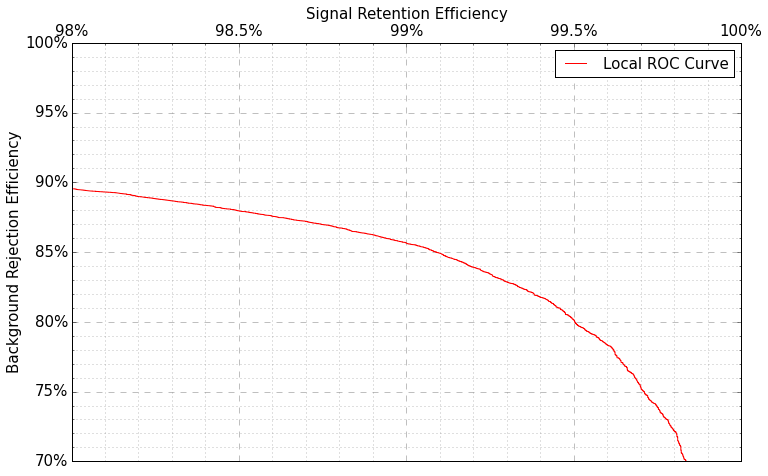

In [67]:
plot_roc_curve(hits_cdc.data[hits_cdc.hit_type_name][np.logical_or(hit_masks[2],hit_masks[3])], 
               hits_cdc.data[ngh_scr_name][np.logical_or(hit_masks[2],hit_masks[3])], 
               zoom=True, label="Local ROC Curve")
print roc_auc_score(hits_cdc.data[hits_cdc.hit_type_name][np.logical_or(hit_masks[2],hit_masks[3])], 
               hits_cdc.data[ngh_scr_name][np.logical_or(hit_masks[2],hit_masks[3])])
plt.show()

In [68]:
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = abs(hits_cdc.data[hits_cdc.hit_type_name][hit_masks[2]]
                        - hits_cdc.data[ngh_scr_name][hit_masks[2]]) ** 2

In [69]:
print roc_auc_score(hits_cdc.data[hits_cdc.hit_type_name][hit_masks[2]], 
                    hits_cdc.data[ngh_scr_name][hit_masks[2]])
print roc_auc_score(hits_cdc.data[hits_cdc.hit_type_name][hit_masks[2]], 
                    hits_cdc.data[ngh_scr_name][hit_masks[2]],
                    sample_weight=problem_weights_2)

0.982085443783
0.19371627474


In [71]:
from tracking import HoughSpace

default = [[31.5, 34, 34.5, 2]]
submatrices = []

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(geom, sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                       sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [72]:
import tracking
reload(tracking)

<module 'tracking' from '../modules/tracking.pyc'>

In [73]:
from tracking import HoughTransformer, HoughShifter
# Fit and transform the second data sample
hough_transformer = HoughTransformer(new_correspondence, \
                                     hough.norm_track_neighs,\
                                     hits_cdc.get_measurement(ngh_scr_name,
                                                              events=evt_samp[2],
                                                              only_hits=False,
                                                              flatten=False),
                                     alpha_max=2., alpha_rw=2.)

In [75]:
# Get the hough results
#hough_score, hough_images = \
hits_cdc.data[hgh_scr_name], hough_images = \
        hough_transformer.transform(hits_cdc.get_measurement(ngh_scr_name, 
                                                             only_hits=False, 
                                                             flatten=False),
                                   only_hits=True, flatten=True)

(array([  3.16712243e+00,   1.08140922e-01,   4.07974037e-02,
          1.73507383e-02,   7.43455969e-03,   3.20242114e-03,
          1.47249589e-03,   7.41396534e-04,   3.29509571e-04,
          1.33863263e-04]),
 array([-0.06690684,  0.23189266,  0.53069217,  0.82949168,  1.12829118,
         1.42709069,  1.7258902 ,  2.0246897 ,  2.32348921,  2.62228872,
         2.92108822]),
 <a list of 10 Patch objects>)

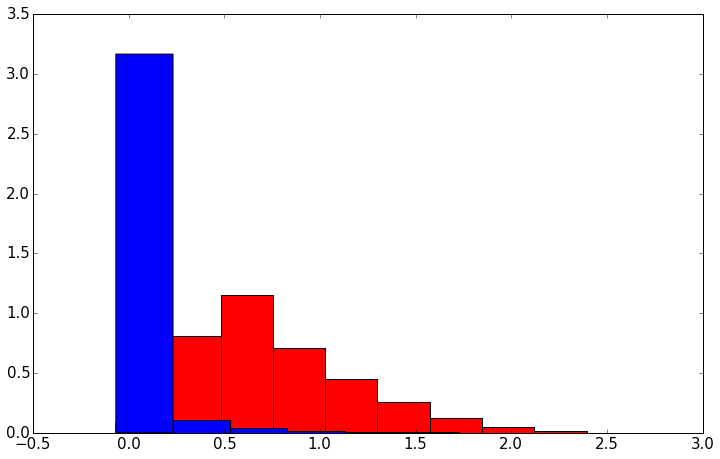

In [76]:
plt.hist(hits_cdc.get_signal_hits(evt_samp[3])[hgh_scr_name], normed=True)
plt.hist(hits_cdc.get_background_hits(evt_samp[3])[hgh_scr_name], normed=True)

In [77]:
# Add this to the feature list
track_train_features = neigh_train_features + [hgh_scr_name]

# Define the new classifier
hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=track_train_features) 

# Define GBDT over only energy deposit to compare
dep_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                               features=[hits_cdc.edep_name])

# Ensure neigh-level GBDT has enough trees to compare properly
neigh_gbdt.set_params(n_estimators=200)
local_gbdt.set_params(n_estimators=200)

# Add the classifiers
factory.add_classifier('Track, Local and Neighbour Features', hough_gbdt)
factory.add_classifier('Energy Deposition', dep_gbdt)

In [78]:
# Train the classifier
factory.fit(DataFrame(np.vstack(
                    [hits_cdc.get_measurement(hits_cdc.edep_name, 
                                              evt_samp[2], 
                                              shift=i, 
                                              only_hits=True, 
                                              flatten=True) for i in [0,-1,1]] +\
                    [hits_cdc.get_measurement(hits_cdc.time_name, 
                                              evt_samp[2], 
                                              shift=i, 
                                              only_hits=True, 
                                              flatten=True) for i in [0,-1,1]] +\
                    [hits_cdc.get_measurement(hits_cdc.row_name,
                                              evt_samp[2],
                                              only_hits=True,
                                              flatten=True)] +\
                    [hits_cdc.get_measurement(hgh_scr_name,
                                              evt_samp[2],
                                              only_hits=True,
                                              flatten=True)]).T,
                    columns=track_train_features), 
            hits_cdc.get_measurement(hits_cdc.hit_type_name,
                                      evt_samp[2],
                                      only_hits=True,
                                      flatten=True))
pass

model Local Features was trained in 81.07 seconds
model Neighbour and Local Features was trained in 157.04 seconds
model Hough, Local and Neighbour Features was trained in 83.52 seconds
model Energy Deposition was trained in 45.47 seconds
Totally spent 367.10 seconds on training


In [79]:
# Test it on the last set of data
hits_cdc.data[trk_scr_name] = hough_gbdt.predict_proba(
        DataFrame(np.vstack(
                        [hits_cdc.get_measurement(hits_cdc.edep_name, 
                                                  shift=i, 
                                                  only_hits=True, 
                                                  flatten=True) for i in [0,-1,1]] +\
                        [hits_cdc.get_measurement(hits_cdc.time_name, 
                                                  shift=i, 
                                                  only_hits=True, 
                                                  flatten=True) for i in [0,-1,1]] +\
                        [hits_cdc.get_measurement(hits_cdc.row_name,
                                                  only_hits=True,
                                                  flatten=True)] +\
                        [hits_cdc.get_measurement(hgh_scr_name,
                                                  only_hits=True,
                                                  flatten=True)]).T,
                        columns=track_train_features)
        )[:,1]
# Invalidate the training sample
hits_cdc.data[trk_scr_name][np.logical_not(hit_masks[3])] = -1

In [80]:
final_diagnostics = factory.test_on( DataFrame(np.vstack(
                        [hits_cdc.get_measurement(hits_cdc.edep_name, 
                                                  shift=i,
                                                  events=evt_samp[3],
                                                  only_hits=True, 
                                                  flatten=True) for i in [0,-1,1]] +\
                        [hits_cdc.get_measurement(hits_cdc.time_name, 
                                                  shift=i,
                                                  events=evt_samp[3],
                                                  only_hits=True, 
                                                  flatten=True) for i in [0,-1,1]] +\
                        [hits_cdc.get_measurement(hits_cdc.row_name,
                                                  events=evt_samp[3],
                                                  only_hits=True,
                                                  flatten=True)] +\
                        [hits_cdc.get_measurement(hgh_scr_name,
                                                  events=evt_samp[3],
                                                  only_hits=True,
                                                  flatten=True)]).T,
                        columns=track_train_features), 
                                    hits_cdc.get_measurement(hits_cdc.hit_type_name,
                                    events=evt_samp[3],
                                      only_hits=True,
                                      flatten=True))

In [121]:
%run visualizations.ipynb

Populating the interactive namespace from numpy and matplotlib


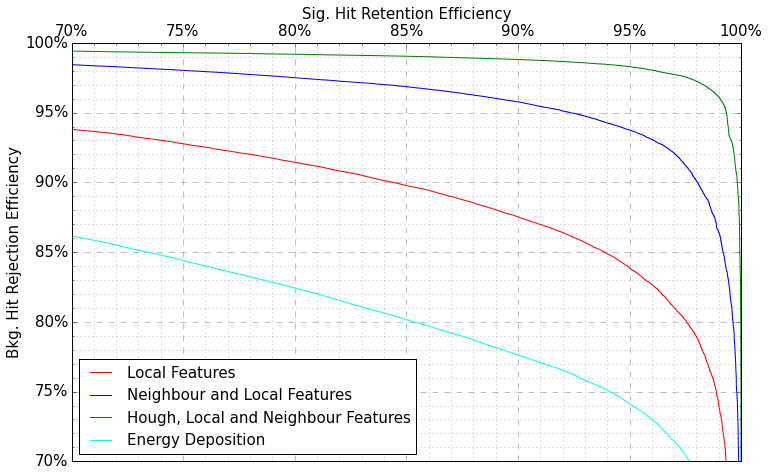

In [125]:
plot_set_font()
figsize(12, 7.5)
plot_rocs( hits_cdc.get_measurement(hits_cdc.hit_type_name,
                                    events=evt_samp[3],
                                      only_hits=True,
                                      flatten=True), 
          final_diagnostics.prediction, 
          zoom=True,
          datum_label="Hit")
plt.show()

In [101]:
labels = np.take([0,2,1], hits_cdc.get_measurement("CDCHit.fIsSig", 
                                   default=-1, 
                                   only_hits=True,
                                   flatten=True).astype(int) + 1)

(<matplotlib.axes._subplots.AxesSubplot at 0x1ba87590>,
 <matplotlib.figure.Figure at 0xb640890>)

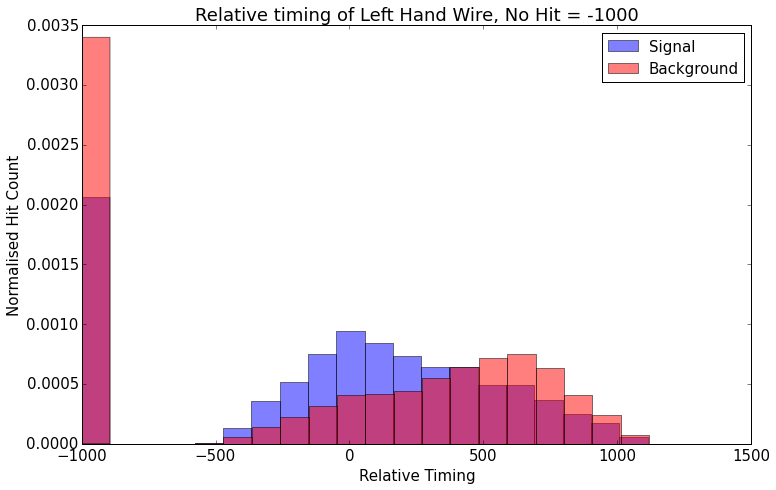

In [143]:
figsize(12, 7.5)
plot_feature( hits_cdc.get_measurement(rel_time_name, flatten=True, shift=-1, default=-1000), 
              labels, 
              xlabel="Relative Timing", ylabel="Normalised Hit Count", xlog=False,
              title="Relative timing of Left Hand Wire, No Hit = -1000", nbins=20)

(<matplotlib.axes._subplots.AxesSubplot at 0x1bf71b10>,
 <matplotlib.figure.Figure at 0x88c3210>)

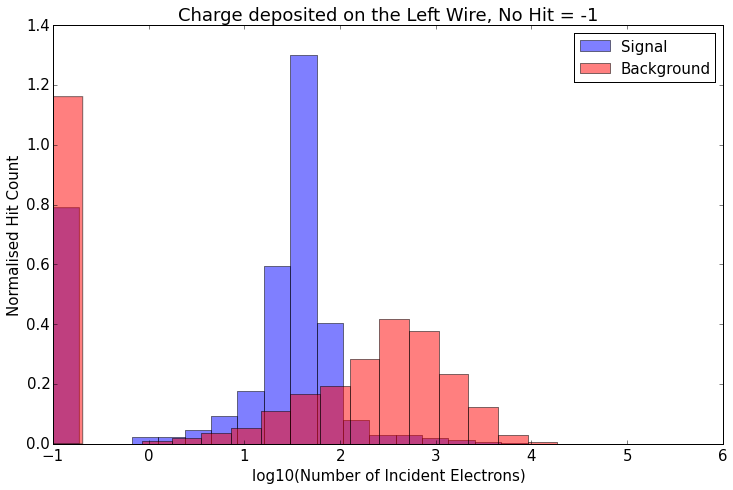

In [146]:
figsize(12, 7.5)
plot_feature( np.log10(hits_cdc.get_measurement(hits_cdc.edep_name, flatten=True, shift=-1) + 0.1), 
              labels, 
              xlabel="log10(Number of Incident Electrons)", 
              ylabel="Normalised Hit Count", xlog=False,
              title="Charge deposited on the Left Wire, No Hit = -1", nbins=20)

(<matplotlib.axes._subplots.AxesSubplot at 0x1b20d990>,
 <matplotlib.figure.Figure at 0x1b208c50>)

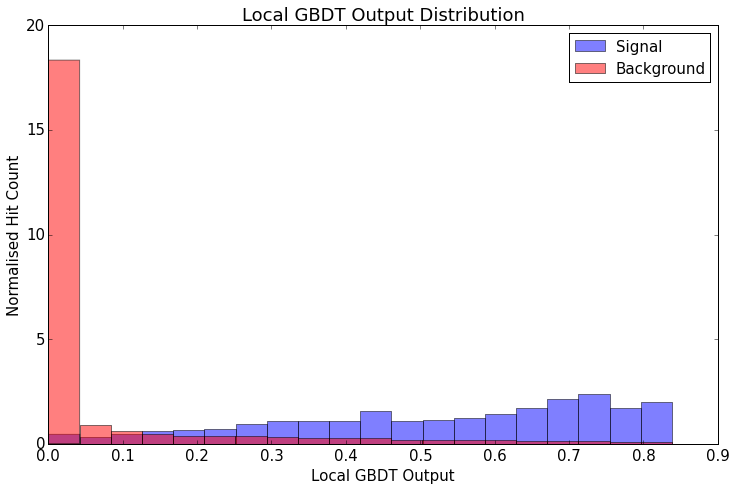

In [104]:
plot_feature( hits_cdc.get_events()[lcl_scr_name][np.logical_not(hit_masks[0])], 
              labels[np.logical_not(hit_masks[0])], 
              xlabel="Local GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Local GBDT Output Distribution", nbins=20)

(<matplotlib.axes._subplots.AxesSubplot at 0x5497d50>,
 <matplotlib.figure.Figure at 0x1b8a1c10>)

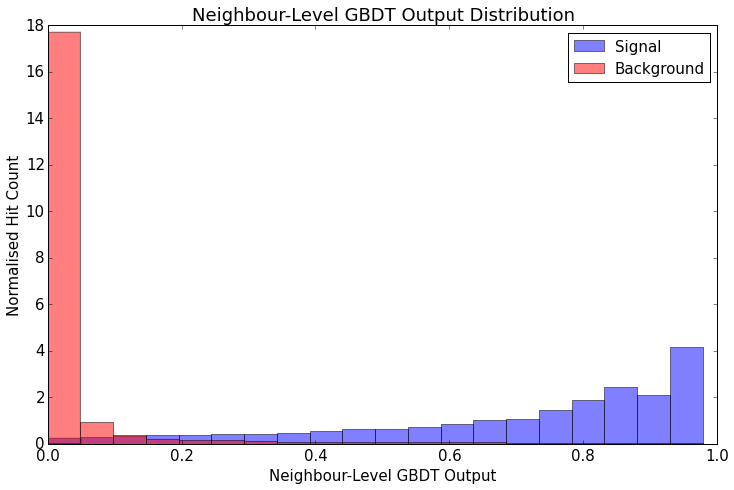

In [111]:
plot_feature( hits_cdc.get_events()[ngh_scr_name][np.logical_or(hit_masks[2], hit_masks[3])], 
              labels[np.logical_or(hit_masks[2], hit_masks[3])], 
              xlabel="Neighbour-Level GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Neighbour-Level GBDT Output Distribution", nbins=20)

(<matplotlib.axes._subplots.AxesSubplot at 0x55c7b10>,
 <matplotlib.figure.Figure at 0x5497390>)

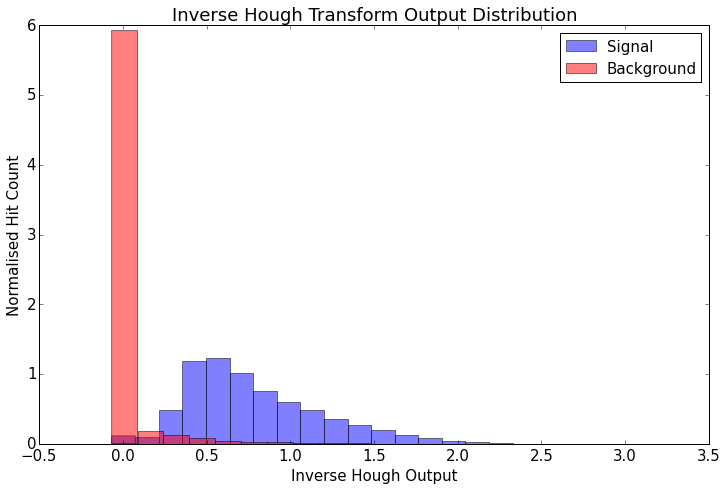

In [110]:
plot_feature( hits_cdc.get_events()[hgh_scr_name][np.logical_or(hit_masks[2], hit_masks[3])], 
              labels[np.logical_or(hit_masks[2], hit_masks[3])], 
              xlabel="Inverse Hough Output", ylabel="Normalised Hit Count", xlog=False,
              title="Inverse Hough Transform Output Distribution", nbins=20)

(<matplotlib.axes._subplots.AxesSubplot at 0x15cdab10>,
 <matplotlib.figure.Figure at 0x1b5d3bd0>)

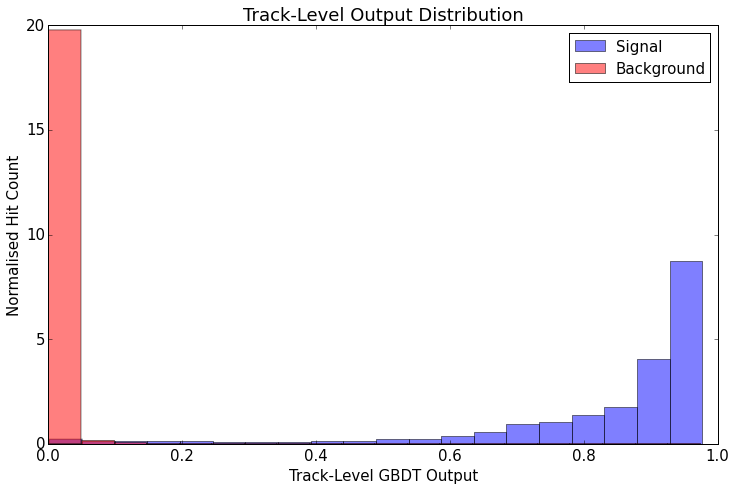

In [114]:
plot_feature( hits_cdc.get_events()[trk_scr_name][hit_masks[3]], 
              labels[hit_masks[3]], 
              xlabel="Track-Level GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Track-Level Output Distribution", nbins=20)

In [130]:
# TODO clean this up
from collections import OrderedDict

figsize(6.4,6.4) 
feat_label_dict = OrderedDict([
            (rel_time_name,               "Timing"),  
            (rel_time_name     +"_left",  "Left Timing"),  
            (rel_time_name     +"_right", "Right Timing"),  
            (hits_cdc.edep_name,          "Energy"),  
            (hits_cdc.edep_name+"_left",  "Left Energy"),  
            (hits_cdc.edep_name+"_right", "Right Energy"),  
            (hits_cdc.row_name,           "R Distance"),  
            (hgh_scr_name,               r"Hough, $W_j''$")
    ])

def plot_feature_importance(rep_classifier, feat_label_dict):
    feat_import = rep_classifier.get_feature_importances()
    feat_import = feat_import.sort("effect", ascending=False)
    ax = plt.subplot(111)
    ax.bar( np.arange(len(feat_import.values)), feat_import.values,zorder=10)
    ax.set_xticks(np.arange(len(feat_import.values))+0.5)
    ax.minorticks_on()
    ax.set_ylabel("Normalized Relative Usage")
    ax.set_title("Feature Importance")
    ax.autoscale()
    ax.grid(b=True, which='major', axis='y' ,color='grey', linestyle='--')
    ax.grid(b=True, which='minor', axis='y' , color='grey', linestyle=':')
    ordered_labels = OrderedDict((key, feat_label_dict[key]) for key in feat_import.index.values)
    ax.set_xticklabels(ordered_labels.values(),  rotation='vertical')
    ax.set_yticklabels(["{:.0f}%".format(tick*100) for tick in ax.get_yticks()])
    return ax

def plot_feature_correlations(rep_factory, feat_label_dict):
    corr = rep_factory.features_correlation_matrix(features=feat_label_dict.keys(),
                                tick_labels=feat_label_dict.values())
    corr.fontsize = 15
    corr.cmap = "RdBu"
    return corr.plot()

In [ ]:
figsize(6.4,6.4) 
plot_feature_importance(neigh_gbdt, feat_label_dict)
show()
plot_feature_correlations(final_diagnostics, feat_label_dict)
show()

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


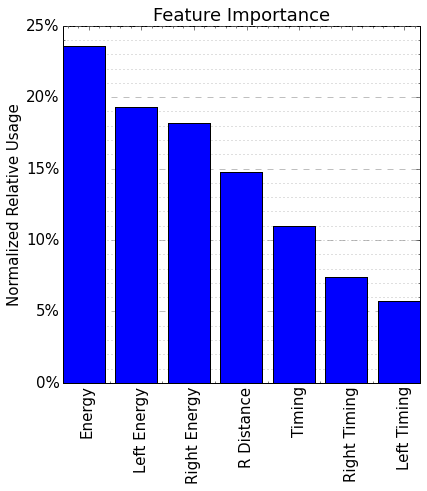

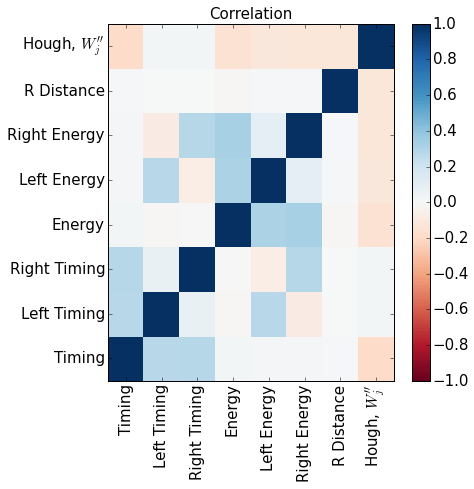

In [148]:
figsize(6.4,6.4) 
plot_feature_importance(neigh_gbdt, feat_label_dict)
show()
plot_feature_correlations(final_diagnostics, feat_label_dict)
show()

# BEGIN OLD STATISTICS

(<matplotlib.axes._subplots.AxesSubplot at 0x2b0707d0>,
 <matplotlib.figure.Figure at 0x71e1e50>)

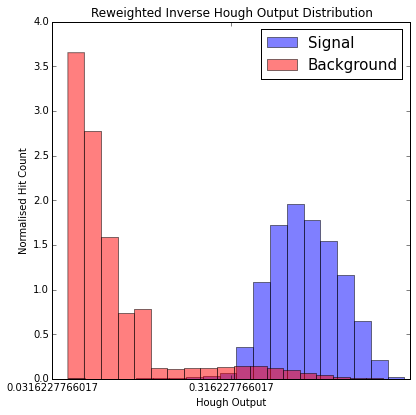

In [63]:
plot_feature( (data_3['Hough'].values+0.1), data_3['labels'].values, 
             xlabel="Hough Output", ylabel="Normalised Hit Count", xlog=True,
            title="Reweighted Inverse Hough Output Distribution", nbins=20)

In [64]:
print roc_auc_score(mask(data_3)['is_signal'], pred_final_3)

0.997283854588


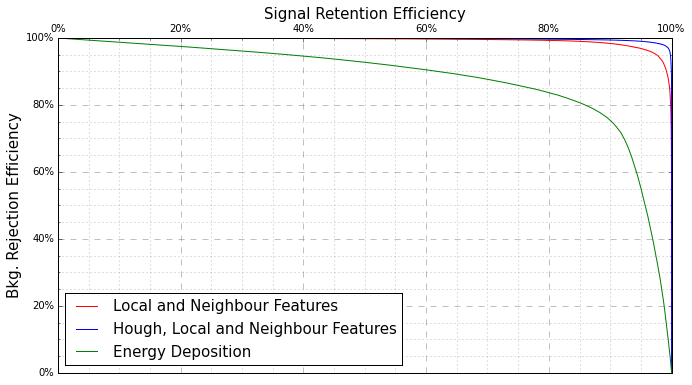

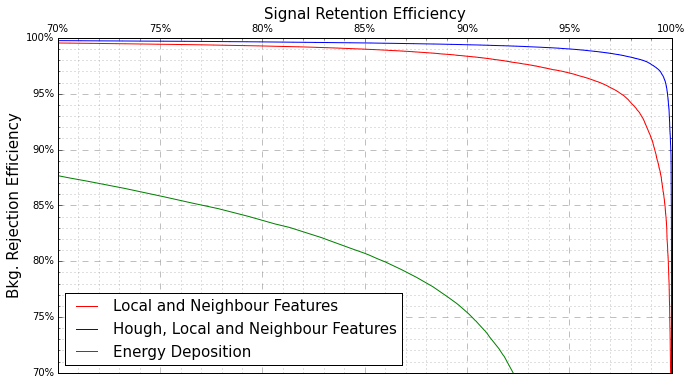

In [65]:
figsize(11,6) 
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=False)
#plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc.png", bbox_inches="tight")
show()
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=True)
#plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc_zoom.png", bbox_inches="tight")
show()

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


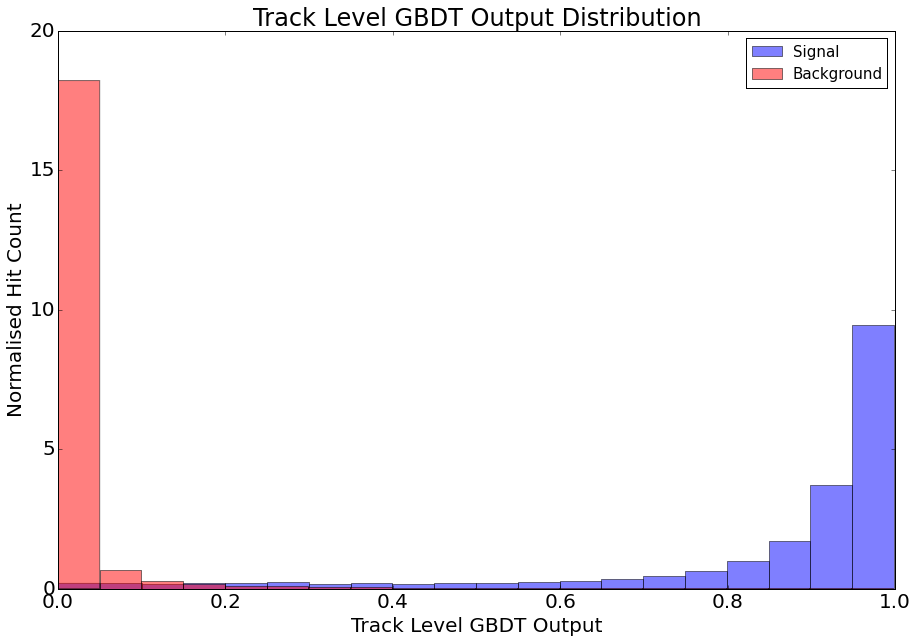

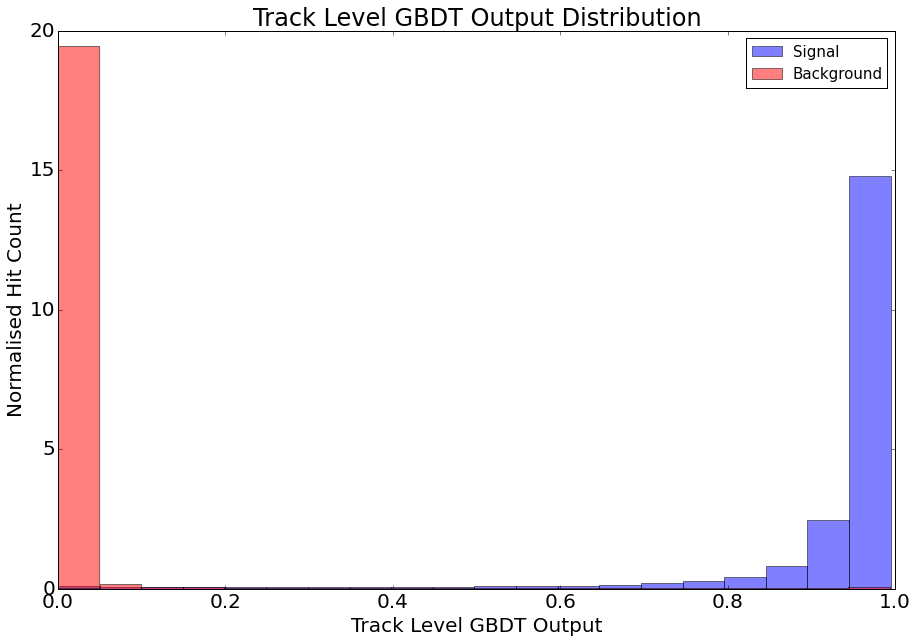

In [66]:
figsize(15,10)
plot_set_font(size=20)
plot_feature( pred_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count", 
            title="Track Level GBDT Output Distribution", nbins=20)
show()
plot_feature( pred_final_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count",
            title="Track Level GBDT Output Distribution", nbins=20)
show()

In [67]:
problem_weights_3 = (mask(data_3)['labels'] != 0) * abs(mask(data_3)['is_signal'] - pred_3) ** 2
print roc_auc_score(mask(data_3)['is_signal'], pred_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_3, sample_weight=problem_weights_3)

0.992753122642
0.148320262942


# END OLD STATISTICS

## Visualiaze the Data

In [88]:
# Event information\
event_in_samp = 10
event = evt_samp[3][event_in_samp]
add_trans = True
save = True
savedir = "/vols/comet00/users/elg112/ICEDUST/track-finding-yandex/icedust_example/"

to_plot = np.take([0,2,1], hits_cdc.get_measurement("CDCHit.fIsSig", 
                                   events=event, 
                                   default=-1, 
                                   only_hits=False,
                                   flatten=True).astype(int) + 1)
ngh_pred_size = plot_norm_size(hits_cdc.get_measurement(ngh_scr_name, 
                                                        events=event, 
                                                        default=-1, 
                                                        only_hits=False,
                                                        flatten=True))
trk_pred_size = plot_norm_size(hits_cdc.get_measurement(trk_scr_name, 
                                                        events=event, 
                                                        default=-1, 
                                                        only_hits=False,
                                                        flatten=True))
hough_output = hits_cdc.get_measurement(hgh_scr_name, 
                                        events=event, 
                                        default=0, 
                                        only_hits=False,
                                        flatten=True)
plot_hough_image_3 = hough_images[event,:hough.track.n_points] + hough_images[event,hough.track.n_points:] 

In [89]:
print hough_output.shape

(4482,)


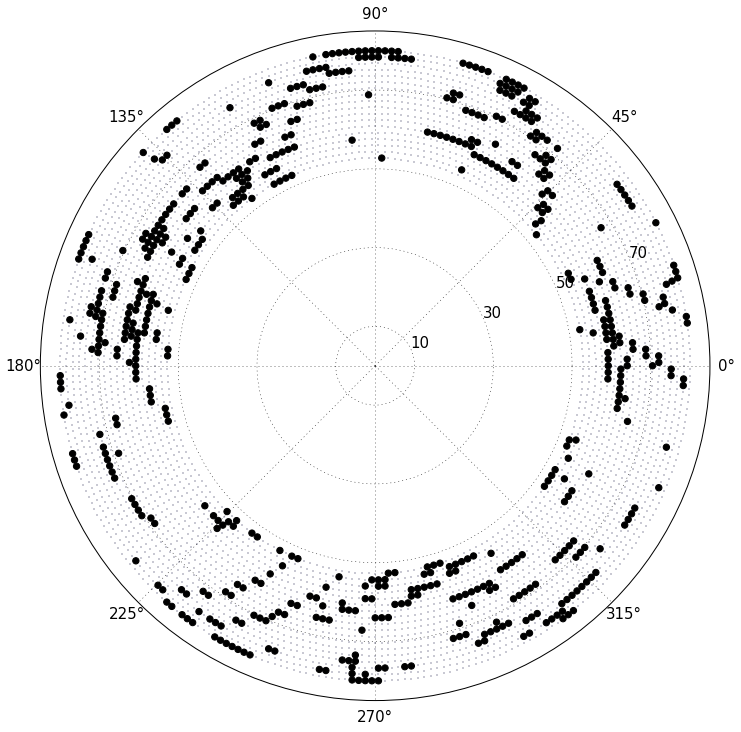

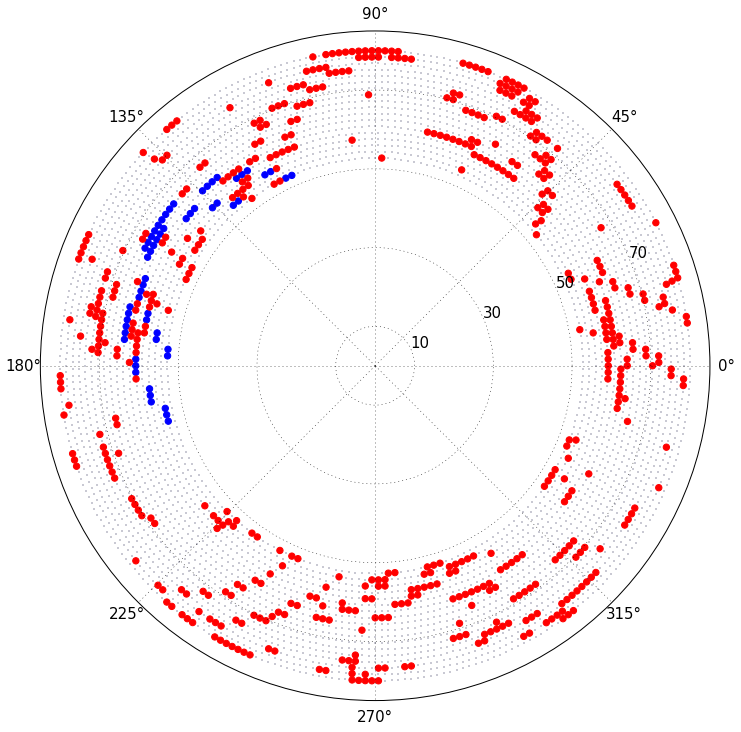

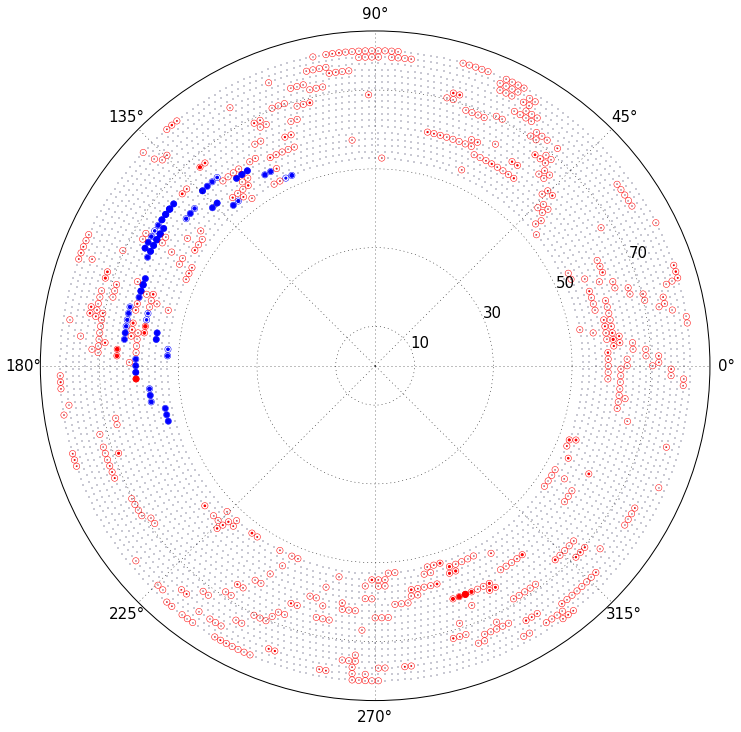

Length of draw tracks are 37


/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


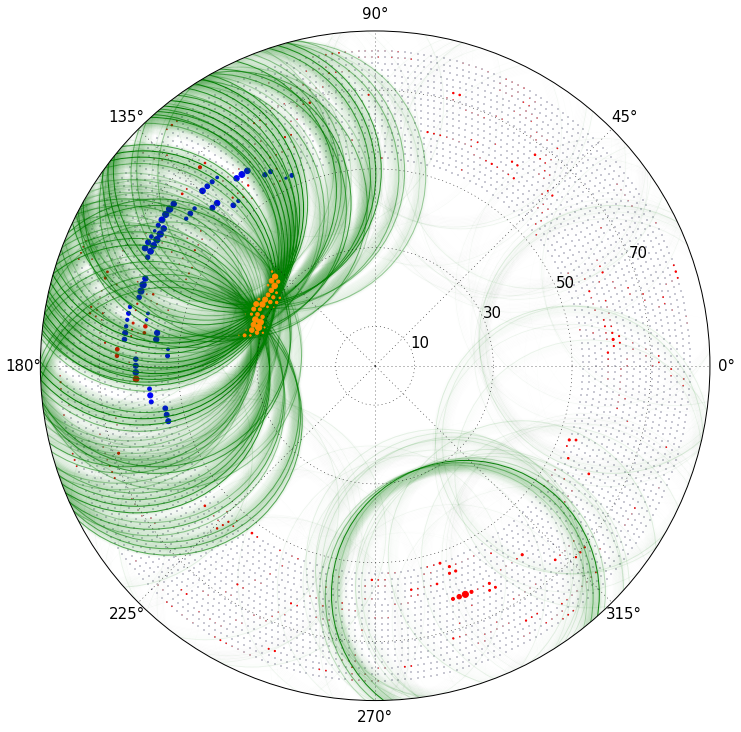

Length of draw tracks are 37


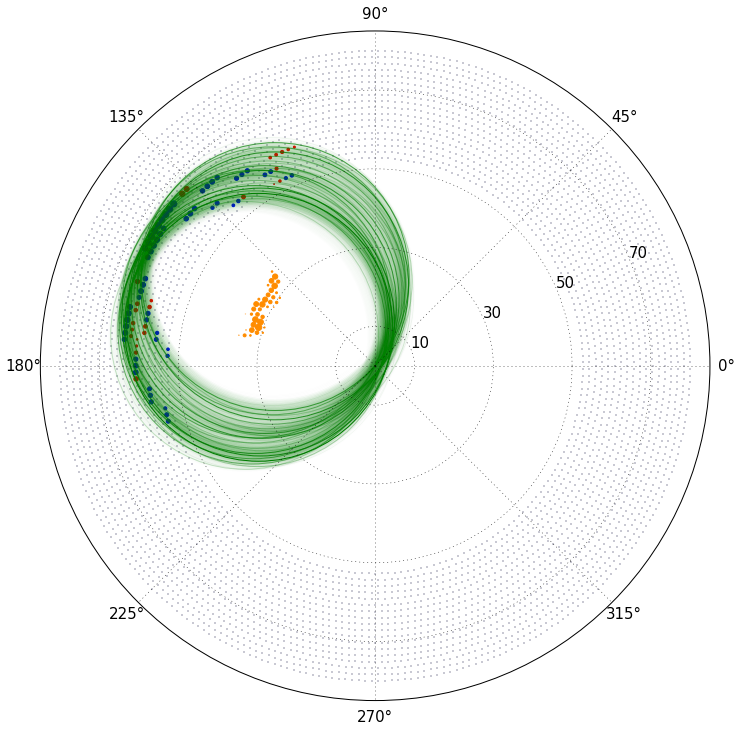

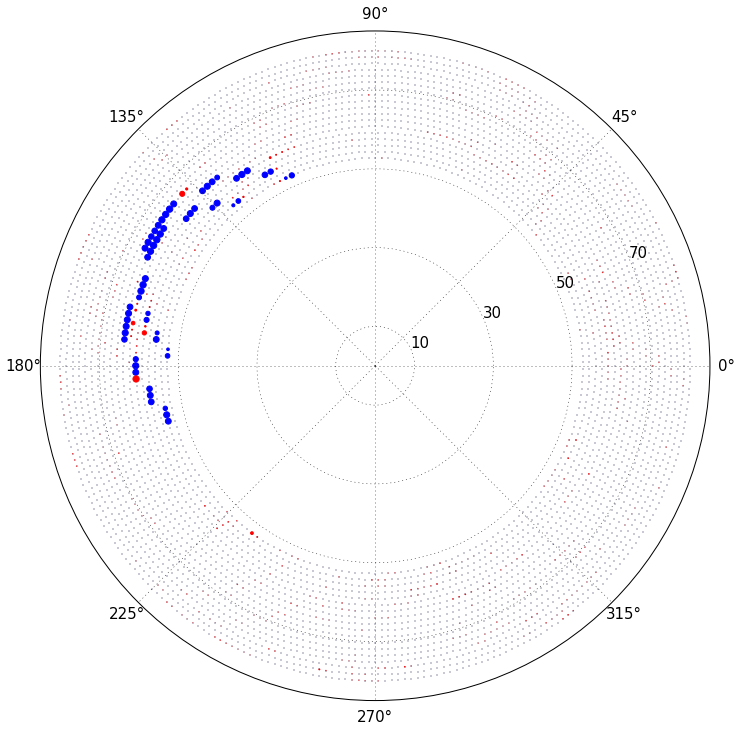

In [90]:
# Basic output
plot_output(to_plot, geom, sig_color='black', bkg_color='black', )
if save:
    plt.savefig(savedir+"plot_event_bw.png", bbox_inches='tight')
show()

plot_output(to_plot, geom)
if save:
    plt.savefig(savedir+"plot_event.png", bbox_inches='tight')
show()

# First GBDT output
plot_output(to_plot, geom, 
            size=ngh_pred_size)
plot_add_outlines(to_plot, geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()

# Hough output
plot_output(to_plot, geom, 
            size=ngh_pred_size, 
            add_transform=add_trans)
plot_add_tracks(geom, hough, 
                size=plot_norm_size(plot_hough_image_3,40))
if save:
    plt.savefig(savedir+"plot_hough.png", bbox_inches='tight')
show()

# Inverse Hough output
plot_output(to_plot, geom, 
            size=plot_norm_size(hough_output))
plot_add_tracks(geom, hough, 
                size=plot_norm_size(plot_hough_image_3,40), 
                add_transform=add_trans,
                tolerance=0.00)
if save:
    plt.savefig(savedir+"plot_inv_hough.png", bbox_inches='tight')
show()    

# Final
plot_output(to_plot, geom, size=plot_norm_size(trk_pred_size))
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight')
show()

In [70]:
# TODO 
# Plots for Louis

# Penalize for not being the closest point to the fit



# Belle-II literature
# multiple radii
# optimize hough to improve track purity, use RANSAC to shed background islands
# 

#TODO Offline Analysis
# WEDS clean up RANSAC implimentation
# WEDS use shifted hough in RANSAC implimentation
# THURS penalize on no hits for RANSAC
# THURS change sampling probability via GBDT score
# THURS change scoring weight by GBDT score
# FRI check results for mulitple radii, no optimization
# FRI check results for varying hit efficiencies, no optimization


# In[73]:

#TODO Online
# TUES Rebuild notebook for new sample
# TUES Integrate trigger signal in
# TUES Reevaluate the flow of the algorithm


# In[74]:

# MC PRODUCTION
# Timing in Prod. Sec.
#  Determine IO and CPU time for current jobs
#  Determine best cuts to make (most obvious ones anyway)
# ECAL hits
#  After CM18
# Cross-Check occupancy
#  Generate large enough CyDet sample and check occupancy
#  Perhaps do this locally, or atleast the merging part


# In[75]:

# NOTES
## Shifting to align image in hough space must 
#  play well with the placticity already 
#  implimented in the algorithm.  Adjust reweighting
## Try reweighting background hits close to signal hits
#  as worse when we do the track level GBDT algo.  Rid
#  background islands at RANSAC level.

